In [1]:
import os
import sys
import pandas as pd
import yaml 
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from matplotlib import colors as mcolors
from matplotlib import patches as mpatches
import statsmodels.api as sm
import numpy as np
from itertools import product
import subprocess
import networkx as nx

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 11

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
from sklearn.linear_model import LinearRegression

from xgboost import XGBRegressor, XGBClassifier

import shap

with open("../../config.yaml.local", "r") as f:
    LOCAL_CONFIG = yaml.safe_load(f)
with open("../../config.yaml", "r") as f:
    CONFIG = yaml.safe_load(f)
sys.path.append("../python")

import globals
import data_tools as dt
import writing_tools as wt
import utils
import emb

LOCAL_PATH = LOCAL_CONFIG["LOCAL_PATH"]
RAW_DATA_PATH = LOCAL_CONFIG["RAW_DATA_PATH"]
DATA_PATH = LOCAL_CONFIG["DATA_PATH"]
R_PATH = LOCAL_CONFIG["R_PATH"]

RUN_R_SCRIPTS = False
OVERWRITE = False


In [2]:
# Some basic data cleaning / wranging

posts = dt.get_posts()
posts['week'] = dt.as_week(posts['created_at'])

mask = (posts['invoiceActionState'] != 'FAILED') & \
    (~posts['bio']) & (~posts['freebie']) & (~posts['saloon']) & \
    (posts['subName'].notnull()) & (posts['subName'] != '') & \
    (~posts['subName'].isin(['jobs', 'ama'])) & \
    (posts['title'] != 'deleted by author') & \
    (globals.data_end - posts['created_at'] >= pd.Timedelta(hours=48))

posts = posts.loc[mask].reset_index(drop=True)
posts['text'] = posts['text'].fillna('')
posts['num_img_or_links'] = posts['text'].apply(dt.count_image_or_links)
posts['num_words'] = posts['text'].apply(lambda x: len(x.split()))
posts['is_link_post'] = (posts['url'].notnull()) & (posts['url'] != '')
posts['link_only'] = posts['is_link_post'] & (posts['text'].str.strip() == '')

posts['has_img_or_links'] = posts['num_img_or_links'] > 0
posts['no_words'] = posts['num_words'] == 0
posts['lo_words'] = (posts['num_words'] > 0) & (posts['num_words'] <= 50)
posts['hi_words'] = posts['num_words'] > 50

print(len(posts))

c:\Users\edwar\projects\sn-research\src\notebooks\../python\data_tools.py:89: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.dt.to_period('W-SAT').dt.start_time


191334


In [3]:
# Table showing some determinants of post quality

tbl = "\\renewcommand{\\arraystretch}{1.2} \n"
tbl += "\\begin{tabular}{lcccc} \n"
tbl += "\\toprule \n"
tbl += "  & \\multicolumn{1}{c}{Has images or links}  &   \\multicolumn{3}{c}{Number of words} \\\\ \n"
tbl += "  & \\multicolumn{1}{c}{in post body?}        &   None       & 1-50       & >50        \\\\ \\hline  \n"
for link_post in [True, False]:
    if link_post:
        tbl += "\\multirow{6}{*}{Is link post} & "
    else:
        tbl += "\\multirow{6}{*}{Not link post} & "
    for img_or_link in [False, True]:
        if img_or_link:
            tbl += " & \\multirow{3}{*}{Yes} "
        else:
            tbl += "\\multirow{3}{*}{No} "
        for word_cat in ['no_words', 'lo_words', 'hi_words']:
            if (word_cat == 'no_words') & (img_or_link == True):
                tbl += " & "
                continue
            mask = (posts['is_link_post'] == link_post) & (posts['has_img_or_links'] == img_or_link) & (posts[word_cat])
            zaps48 = posts.loc[mask, 'sats48'].mean()
            tbl += f"& $\\bar{{z}} = {zaps48:,.0f}$"
        tbl += " \\\\ \n"
        tbl += " & "
        for word_cat in ['no_words', 'lo_words', 'hi_words']:
            if (word_cat == 'no_words') & (img_or_link == True):
                tbl += " & "
                continue
            mask = (posts['is_link_post'] == link_post) & (posts['has_img_or_links'] == img_or_link) & (posts[word_cat])
            comments48 = posts.loc[mask, 'comments48'].mean()
            tbl += f"& $\\bar{{c}} = {comments48:,.1f}$"
        tbl += " \\\\ \n"
        tbl += " & "
        for word_cat in ['no_words', 'lo_words', 'hi_words']:
            if (word_cat == 'no_words') & (img_or_link == True):
                tbl += " & "
                continue
            mask = (posts['is_link_post'] == link_post) & (posts['has_img_or_links'] == img_or_link) & (posts[word_cat])
            n_posts = len(posts.loc[mask])
            tbl += f"& $N = {n_posts:,.0f}$"
        if img_or_link == False:
            tbl += " \\\\ \\cline{2-5} \n "
        else:
            tbl += " \\\\ \\hline \n"
tbl += "\\end{tabular} \n"
tbl += "\\renewcommand{\\arraystretch}{1} \n"
print(tbl)

with open(os.path.join(LOCAL_PATH, "results", "tbl_quality_determinants.tex"), "w") as f:
    f.write(tbl)


\renewcommand{\arraystretch}{1.2} 
\begin{tabular}{lcccc} 
\toprule 
  & \multicolumn{1}{c}{Has images or links}  &   \multicolumn{3}{c}{Number of words} \\ 
  & \multicolumn{1}{c}{in post body?}        &   None       & 1-50       & >50        \\ \hline  
\multirow{6}{*}{Is link post} & \multirow{3}{*}{No} & $\bar{z} = 166$& $\bar{z} = 214$& $\bar{z} = 250$ \\ 
 & & $\bar{c} = 1.2$& $\bar{c} = 2.4$& $\bar{c} = 2.7$ \\ 
 & & $N = 91,721$& $N = 10,392$& $N = 10,486$ \\ \cline{2-5} 
  & \multirow{3}{*}{Yes}  & & $\bar{z} = 202$& $\bar{z} = 513$ \\ 
 &  & & $\bar{c} = 1.3$& $\bar{c} = 3.5$ \\ 
 &  & & $N = 6,308$& $N = 5,899$ \\ \hline 
\multirow{6}{*}{Not link post} & \multirow{3}{*}{No} & $\bar{z} = 309$& $\bar{z} = 371$& $\bar{z} = 706$ \\ 
 & & $\bar{c} = 7.0$& $\bar{c} = 8.6$& $\bar{c} = 10.1$ \\ 
 & & $N = 1,725$& $N = 8,917$& $N = 15,251$ \\ \cline{2-5} 
  & \multirow{3}{*}{Yes}  & & $\bar{z} = 280$& $\bar{z} = 1,303$ \\ 
 &  & & $\bar{c} = 3.7$& $\bar{c} = 8.0$ \\ 
 &  & & $N = 17,

In [4]:
# High quality posts

posts['hi_quality'] = (posts['hi_words'] & ~posts['is_link_post']) | (posts['is_link_post'] & posts['hi_words'] & posts['has_img_or_links'])

wt.update_results({
    "NumberHighQuality": f"{posts['hi_quality'].sum():,.0f}",
    "NumberLowQuality": f"{(~posts['hi_quality']).sum():,.0f}"
})



{'PostsCostElasticity': '-0.265',
 'PostsCostDoublingEffect': '16.8',
 'Zaps48CostElasticity': '0.219',
 'Zaps48CostDoublingEffect': '16.4',
 'Comments48CostElasticity': '0.043',
 'Comments48CostDoublingEffect': '3.0',
 'NumItems': '1,121,485',
 'NumPosts': '207,219',
 'NumComments': '914,266',
 'NumUsers': '11,228',
 'NumTerritories': '117',
 'StartDate': 'June 11, 2021',
 'EndDate': 'October 5, 2025',
 'TotalZaps': '146 million',
 'NonCustodialDate': 'January 3, 2025',
 'TotalCost': '13 million',
 'Sats48': '94',
 'Comments48': '90',
 'NumPostingFeeChanges': '199',
 'AvgPostingCost': '51',
 'AvgSats48': '364',
 'AvgComments48': '3.3',
 'SdPostingCost': '241',
 'SdSats48': '6,662',
 'SdComments48': '9.6',
 'AvgPostingCostCents': '5',
 'NumberHighQuality': '44,682',
 'NumberLowQuality': '146,652'}

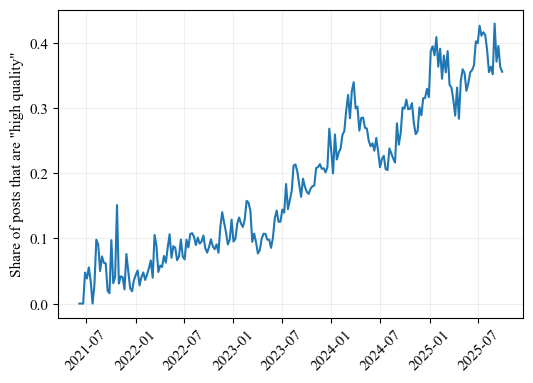

In [5]:
# Plot quality over time

plot_df = posts.groupby('week').agg(
    total_posts = ('itemId', 'count'),
    hi_quality_posts = ('hi_quality', 'sum')
).reset_index()

plt.figure(figsize = (6,4))
plt.plot(plot_df['week'], plot_df['hi_quality_posts'] / plot_df['total_posts'])
plt.xticks(rotation=45)
plt.grid(alpha=0.2)
plt.ylabel('Share of posts that are "high quality"')
plt.savefig(os.path.join(LOCAL_PATH, "results", "fig_quality_over_time.pdf"), bbox_inches='tight')
plt.show()
